In [1]:
import time
import os
import numpy as np 
from scipy import interpolate
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# CLASS tests

In [2]:
from classy import Class
import classy
print('\nUsing CLASS version %s installed at %s'%(classy.__version__,os.path.dirname(classy.__file__)))



Using CLASS version v3.2.3 installed at /Users/ahalder/software/miniconda3/envs/i3PCF/lib/python3.12/site-packages


### Helper fuctions

In [3]:
######################################################################################

## function to compute the eta_0 baryonic feedback parameter

def eta_0_val(c_min):
    return 1.03-0.11*c_min

######################################################################################

## function to compute individual masses of massive neutrinos

def get_masses(sum_masses, hierarchy, delta_m_squared_atm=2.5e-3, delta_m_squared_sol=7.37e-5):
    """ Return individual masses of neutrinos

    Args:
        sum_masses ( float ): sum of neutrino masses
        hierarchy ( string ): Neutrino hierarchy
        delta_m_squared_atm ( float ): squared difference of neutrino masses from atmospheric oscillation experiments
        delta_m_squared_sol ( float ): squared difference of neutrino masses from solar oscillation experiments
    Returns:
        m1, m2, m3: Individual neutrino masses
    """

    if (sum_masses == 0.0):
        # massless neutrino case
        m1 = 0.0
        m2 = 0.0
        m3 = 0.0
        return m1, m2, m3
    
    if (hierarchy == 'DEGENERATE'):
        # degenerate neutrino case
        m1 = sum_masses / 3
        m2 = sum_masses / 3
        m3 = sum_masses / 3
        return m1, m2, m3
    
    elif (hierarchy == 'NORMAL'):
        # delta_m_squared_atm = m_3^2 - (m_1^2 + m_2^2)/2
        # delta_m_squared_sol = m_2^2 - m_1^2
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1, opt_output, success, output_message = fsolve(m1_func, sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol), full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1, m2, m3
    
    elif (hierarchy == 'INVERTED'):
        # Inverted hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_IH and deletes M_tot_IH
        #delta_m_squared_atm = -m_3^2 + (m_1^2 + m_2^2)/2
        #delta_m_squared_sol = m_2^2 - m_1^2
        delta_m_squared_atm = -delta_m_squared_atm
        m1_func = lambda m1, M_tot, d_m_sq_atm, d_m_sq_sol: M_tot**2. + 0.5*d_m_sq_sol - d_m_sq_atm + m1**2. - 2.*M_tot*m1 - 2.*M_tot*(d_m_sq_sol+m1**2.)**0.5 + 2.*m1*(d_m_sq_sol+m1**2.)**0.5
        m1, opt_output, success, output_message = fsolve(m1_func, sum_masses/3.,(sum_masses,delta_m_squared_atm,delta_m_squared_sol),full_output=True)
        m1 = m1[0]
        m2 = (delta_m_squared_sol + m1**2.)**0.5
        m3 = (delta_m_squared_atm + 0.5*(m2**2. + m1**2.))**0.5
        return m1, m2, m3
    
    else:
        raise ValueError('Unknown hierarchy %s'%hierarchy)
    

### Parameters

In [4]:
'''
#### Takahashi cosmology ####
Omega_b = 0.046
Omega_m = 0.279
h = 0.7
sigma8 = 0.82
A_s = 2.1822254496213904e-09
n_s = 0.97
w0 = -1.0
wa = 0.0
c_min = 3.13
eta_0 = eta_0_val(c_min)
Mv = 0.1
'''

#### COSMOGRIDV1 cosmology ####
Omega_b = 0.0493
Omega_m = 0.26
h = 0.673
sigma8 = 0.84
#A_s = 2.9509837679531363e-09
n_s = 0.9649
w0 = -1.0
wa = 0.0
c_min = 3.13
eta_0 = eta_0_val(c_min)
Mv = 0.06

### Setup CLASS object

In [5]:
class_settings  = {
            'h':h,
            'Omega_b':Omega_b,
            'Omega_m':Omega_m,
            'n_s':n_s,
            'Omega_Lambda':0.0,
            'fluid_equation_of_state':'CLP',
            'w0_fld':w0,
            'wa_fld':wa,
            'output':'mPk',
            'P_k_max_1/Mpc':180.0,
            'z_max_pk':3.0,
            'non linear':'hmcode',
            'c_min':c_min,
            'eta_0':eta_0,
            }

if (Mv != 0.0):
    # for massive neutrinos

    m1, m2, m3 = get_masses(Mv, 'DEGENERATE') # degenerate neutrinos (e.g. in COSMOGRIDV1)
    #m1, m2, m3 = get_masses(Mv, 'NORMAL', 2.5e-3, 7.37e-5) # normal hierarchy neutrinos
    #m1, m2, m3 = get_masses(Mv, 'INVERTED', 2.5e-3, 7.37e-5) # inverted hierarchy neutrinos
    
    print('Neutrino masses --> m1, m2, m3 in [eV] =', m1, m2, m3)

    class_settings['N_ur'] = 0.00441
    class_settings['N_ncdm'] = 3
    class_settings['m_ncdm'] = str(m1)+','+str(m2)+','+str(m3)
    #class_settings['ncdm_fluid_approximation'] = 3 # will result in significantly slower running

class_settings['sigma8'] = sigma8
#class_settings['A_s'] = A_s

#### CLASS computation for non-linear power spectrum #####
class_start = time.time()

cclass = Class()
cclass.set(class_settings)
cclass.compute()

class_end = time.time()

print('CLASS computation time (seconds):', class_end - class_start)

Neutrino masses --> m1, m2, m3 in [eV] = 0.02 0.02 0.02
CLASS computation time (seconds): 14.057039737701416


In [6]:
print('Omega_b =', cclass.Omega_b())
print('Omega_cdm =', cclass.Omega0_cdm())
print('Omega_nu =', cclass.Omega_nu)
print('Omega_b + Omega_cdm + Omega_nu =', cclass.Omega_b() + cclass.Omega0_cdm() + cclass.Omega_nu)
print('Omega_m =', cclass.Omega_m())
print('Omega_g =', cclass.Omega_g())
print('Omega_r =', cclass.Omega_r())
print('N_eff =', cclass.Neff())
print('A_s =', cclass.get_current_derived_parameters(['A_s'])['A_s'])
print('sigma8 =', cclass.sigma8())
print('S8 =', cclass.S8())
print('Omega_Lambda =', cclass.Omega_Lambda())
print('Omega_k =', cclass.Omega0_k())
print('h =', cclass.h())
print('n_s =', cclass.n_s())

Omega_b = 0.0493
Omega_cdm = 0.2092771208859442
Omega_nu = 0.0014228791140558066
Omega_b + Omega_cdm + Omega_nu = 0.26
Omega_m = 0.25999869997027936
Omega_g = 5.459971167360351e-05
Omega_r = 5.5954425368086505e-05
N_eff = 3.044004664360296
A_s = 3.069798834826492e-09
sigma8 = 0.8400001501207897
S8 = 0.7819956271648156
Omega_Lambda = 0.0
Omega_k = 0.0
h = 0.673
n_s = 0.9649


### Background quantities

In [7]:
cclass.get_background()

{'z': array([1.00000000e+14, 9.99194400e+13, 9.98389448e+13, ...,
        1.61314959e-03, 8.06249775e-04, 0.00000000e+00]),
 'proper time [Gyr]': array([7.55951614e-26, 7.57171078e-26, 7.58392508e-26, ...,
        1.45442647e+01, 1.45559684e+01, 1.45676757e+01]),
 'conf. time [Mpc]': array([4.63478500e-09, 4.63842298e-09, 4.64387995e-09, ...,
        1.52777724e+04, 1.52813651e+04, 1.52849560e+04]),
 'H [1/Mpc]': array([2.15725697e+22, 2.15378259e+22, 2.15031382e+22, ...,
        2.24630092e-04, 2.24559289e-04, 2.24488636e-04]),
 'comov. dist.': array([1.52849560e+04, 1.52849560e+04, 1.52849560e+04, ...,
        7.18362323e+00, 3.59092989e+00, 0.00000000e+00]),
 'ang.diam.dist.': array([1.52849560e-10, 1.52972795e-10, 1.53096130e-10, ...,
        7.17205364e+00, 3.58803704e+00, 0.00000000e+00]),
 'lum. dist.': array([1.52849560e+18, 1.52726425e+18, 1.52603388e+18, ...,
        7.19521149e+00, 3.59382508e+00, 0.00000000e+00]),
 'comov.snd.hrz.': array([2.67631663e-09, 2.67847441e-09, 2.

In [8]:
cclass.get_background()['z']

array([1.00000000e+14, 9.99194400e+13, 9.98389448e+13, ...,
       1.61314959e-03, 8.06249775e-04, 0.00000000e+00])

In [9]:
cclass.get_background()['H [1/Mpc]']

array([2.15725697e+22, 2.15378259e+22, 2.15031382e+22, ...,
       2.24630092e-04, 2.24559289e-04, 2.24488636e-04])

In [10]:
cclass.get_background()['comov. dist.']

array([1.52849560e+04, 1.52849560e+04, 1.52849560e+04, ...,
       7.18362323e+00, 3.59092989e+00, 0.00000000e+00])

In [11]:
chi_z = interpolate.interp1d(cclass.get_background()['z'], cclass.get_background()['comov. dist.'], kind='cubic', fill_value=0.0)

chi_z(0.01)

array(44.4585577)

In [12]:
15000/chi_z(0.01)

337.3928614829926

### Get sigma8 and growth factor

In [13]:
cclass.sigma8()

0.8400001501207897

In [14]:
#cclass.sigma_prime(8,0.2)

In [15]:
cclass.scale_independent_growth_factor(0.0)

1.0

In [16]:
cclass.scale_independent_growth_factor(0.3)

0.8654830208755467

### Compute matter power spectrum

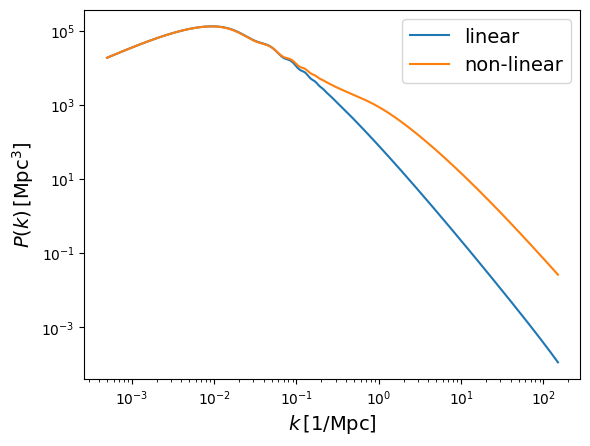

In [17]:
k_arr = np.logspace(np.log10(5e-4),np.log10(150),500)
z_arr = np.array([0.0])

pk_arr_lin = cclass.get_pk_array(k_arr, z_arr, k_arr.size, z_arr.size, 0)
pk_arr_nl = cclass.get_pk_array(k_arr, z_arr, k_arr.size, z_arr.size, 1)

plt.plot(k_arr, pk_arr_lin, label='linear')
plt.plot(k_arr, pk_arr_nl, label='non-linear')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3]$', fontsize=14)
plt.legend(fontsize=14)

In [18]:
k_grid_points_ascending = k_arr
z_grid_points_ascending = np.arange(0.0, 2.51, step=0.05)

In [19]:
# get power spectrum at desired grid points

Pk_array = cclass.get_pk_array(k_grid_points_ascending, z_grid_points_ascending, k_grid_points_ascending.size, z_grid_points_ascending.size, 1).reshape(z_grid_points_ascending.size, k_grid_points_ascending.size).T

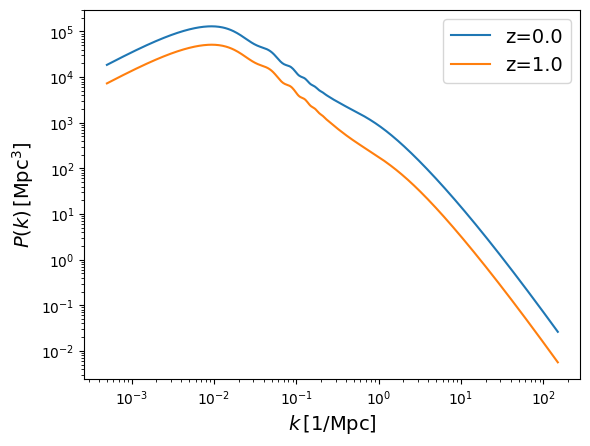

In [20]:
plt.plot(k_grid_points_ascending, Pk_array[:,0], label='z='+str(z_grid_points_ascending[0]))
plt.plot(k_grid_points_ascending, Pk_array[:,20], label='z='+str(z_grid_points_ascending[20]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3]$', fontsize=14)
plt.legend(fontsize=14)

In [21]:
# get power spectrum on pre-computed k,z grid points internally by CLASS

cclass.get_pk_and_k_and_z()[0].shape

(137, 20)

In [22]:
# k values at which the power spectrum is computed

cclass.get_pk_and_k_and_z()[1].shape

(137,)

In [23]:
# redshifts at which the power spectrum is computed

cclass.get_pk_and_k_and_z()[2].shape

(20,)

Text(0, 0.5, '$P(k) \\, [\\mathrm{Mpc}^3]$')

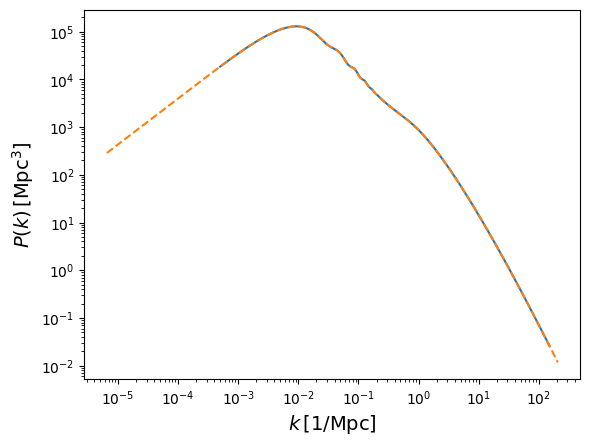

In [24]:
plt.plot(k_grid_points_ascending, Pk_array[:,0])
plt.plot(cclass.get_pk_and_k_and_z()[1], cclass.get_pk_and_k_and_z()[0][:,-1], ls='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$P(k) \, [\mathrm{Mpc}^3]$', fontsize=14)

### Compute the tilt of the matter power spectrum

In [25]:
# compute pk_tilt as a function of k and z using class built-in function

pk_tilt_k_z_array = np.zeros((k_arr.size,3))
pk_nonlinear_tilt_k_z_array = np.zeros((k_arr.size,3))

for i in range(k_arr.size):
    pk_tilt_k_z_array[i, 0] = cclass.pk_tilt(k_arr[i], 0)
    pk_tilt_k_z_array[i, 1] = cclass.pk_tilt(k_arr[i], 1)
    pk_tilt_k_z_array[i, 2] = cclass.pk_tilt(k_arr[i], 2)

    #pk_nonlinear_tilt_k_z_array[i, 0] = cclass.pk_nonlinear_tilt(k_arr[i], 0)
    #pk_nonlinear_tilt_k_z_array[i, 1] = cclass.pk_nonlinear_tilt(k_arr[i], 1)
    #pk_nonlinear_tilt_k_z_array[i, 2] = cclass.pk_nonlinear_tilt(k_arr[i], 2)

In [26]:
# compute pk_tilt as a function of k and z manually using numpy gradient

pk_k_z_array = np.zeros((k_arr.size,3))
pk_nonlinear_k_z_array = np.zeros((k_arr.size,3))

pk_tilt_k_z_array_numpy_gradient = np.zeros((k_arr.size,3))
pk_nonlinear_tilt_k_z_array_numpy_gradient = np.zeros((k_arr.size,3))

for i in range(k_arr.size):
    pk_k_z_array[i, 0] = cclass.pk_lin(k_arr[i], 0)
    pk_k_z_array[i, 1] = cclass.pk_lin(k_arr[i], 1)
    pk_k_z_array[i, 2] = cclass.pk_lin(k_arr[i], 2)

    pk_nonlinear_k_z_array[i, 0] = cclass.pk(k_arr[i], 0)
    pk_nonlinear_k_z_array[i, 1] = cclass.pk(k_arr[i], 1)
    pk_nonlinear_k_z_array[i, 2] = cclass.pk(k_arr[i], 2)

pk_tilt_k_z_array_numpy_gradient[:, 0] = np.gradient(np.log(pk_k_z_array[:, 0]), np.log(k_arr))
pk_tilt_k_z_array_numpy_gradient[:, 1] = np.gradient(np.log(pk_k_z_array[:, 1]), np.log(k_arr))
pk_tilt_k_z_array_numpy_gradient[:, 2] = np.gradient(np.log(pk_k_z_array[:, 2]), np.log(k_arr))

pk_nonlinear_tilt_k_z_array_numpy_gradient[:, 0] = np.gradient(np.log(pk_nonlinear_k_z_array[:, 0]), np.log(k_arr))
pk_nonlinear_tilt_k_z_array_numpy_gradient[:, 1] = np.gradient(np.log(pk_nonlinear_k_z_array[:, 1]), np.log(k_arr))
pk_nonlinear_tilt_k_z_array_numpy_gradient[:, 2] = np.gradient(np.log(pk_nonlinear_k_z_array[:, 2]), np.log(k_arr))

Text(0.5, 1.0, 'Linear pk_tilt')

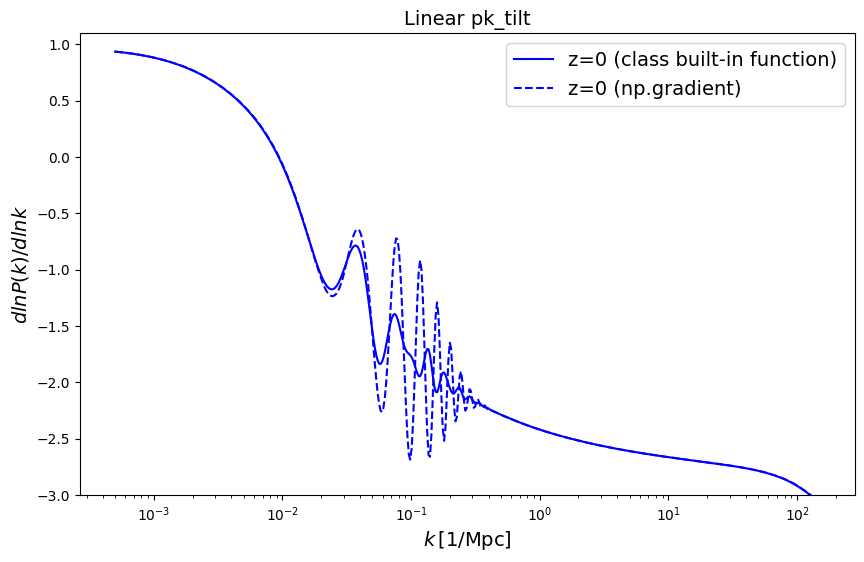

In [27]:
plt.figure(figsize=(10,6))
plt.plot(k_arr, pk_tilt_k_z_array[:,0], c='b', ls='solid', label='z=0 (class built-in function)')
#plt.plot(k_arr, pk_tilt_k_z_array[:,1], c='g', ls='solid', label='z=1 (class built-in function)')
#plt.plot(k_arr, pk_tilt_k_z_array[:,2], c='r', ls='solid', label='z=2 (class built-in function)')
plt.plot(k_arr, pk_tilt_k_z_array_numpy_gradient[:,0], c='b', ls='dashed', label='z=0 (np.gradient)')
#plt.plot(k_arr, pk_tilt_k_z_array_numpy_gradient[:,1], c='g', ls='dashed', label='z=1 (np.gradient)')
#plt.plot(k_arr, pk_tilt_k_z_array_numpy_gradient[:,2], c='r', ls='dashed', label='z=2 (np.gradient)')
plt.xscale('log')
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$dlnP(k)/dlnk$',fontsize=14)
plt.ylim(-3.0,1.1)
plt.legend(fontsize=14)
plt.title('Linear pk_tilt',fontsize=14)

Text(0.5, 1.0, 'Nonlinear pk_tilt')

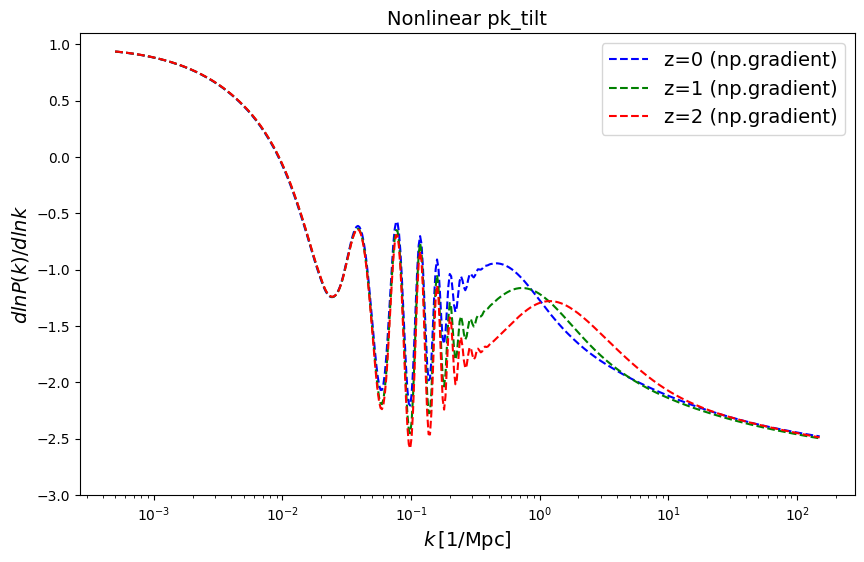

In [28]:
plt.figure(figsize=(10,6))
#plt.plot(k_arr, pk_nonlinear_tilt_k_z_array[:,0], c='b', ls='solid', label='z=0 (class built-in function)')
#plt.plot(k_arr, pk_nonlinear_tilt_k_z_array[:,1], c='g', ls='solid', label='z=1 (class built-in function)')
#plt.plot(k_arr, pk_nonlinear_tilt_k_z_array[:,2], c='r', ls='solid', label='z=2 (class built-in function)')
plt.plot(k_arr, pk_nonlinear_tilt_k_z_array_numpy_gradient[:,0], c='b', ls='dashed', label='z=0 (np.gradient)')
plt.plot(k_arr, pk_nonlinear_tilt_k_z_array_numpy_gradient[:,1], c='g', ls='dashed', label='z=1 (np.gradient)')
plt.plot(k_arr, pk_nonlinear_tilt_k_z_array_numpy_gradient[:,2], c='r', ls='dashed', label='z=2 (np.gradient)')
plt.xscale('log')
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$dlnP(k)/dlnk$',fontsize=14)
plt.ylim(-3.0,1.1)
plt.legend(fontsize=14)
plt.title('Nonlinear pk_tilt',fontsize=14)

## Growth-only response functions (G_1 and G_K)

In [29]:
h = 0.7

RF_G_1_k_table_data = np.loadtxt('../data/response_functions/G_1_k_h.tab', usecols=[0])*h
RF_G_1_z_table_data = np.loadtxt('../data/response_functions/G_1_z.tab', usecols=[0])
RF_G_1_k_z_table_data = np.loadtxt('../data/response_functions/G_1_vals.tab', usecols=[0]).reshape(RF_G_1_k_table_data.size, RF_G_1_z_table_data.size)

RF_G_1_k_z_table = interpolate.RectBivariateSpline(RF_G_1_k_table_data, RF_G_1_z_table_data, RF_G_1_k_z_table_data)
RF_G_1_k_min_table_data = RF_G_1_k_table_data[0]
RF_G_1_k_max_table_data = RF_G_1_k_table_data[-1]
RF_G_1_z_max_table_data = RF_G_1_z_table_data[-1]


RF_G_K_k_table_data = np.loadtxt('../data/response_functions/G_K_k_h.tab', usecols=[0])*h
RF_G_K_z_table_data = np.loadtxt('../data/response_functions/G_K_z.tab', usecols=[0])
RF_G_K_k_z_table_data = np.loadtxt('../data/response_functions/G_K_vals.tab', usecols=[0]).reshape(RF_G_K_k_table_data.size, RF_G_K_z_table_data.size)
RF_G_K_k_z_table = interpolate.RectBivariateSpline(RF_G_K_k_table_data, RF_G_K_z_table_data, RF_G_K_k_z_table_data)
RF_G_K_k_min_table_data = RF_G_K_k_table_data[0]
RF_G_K_k_max_table_data = RF_G_K_k_table_data[-1]
RF_G_K_z_max_table_data = RF_G_K_z_table_data[-1]

In [30]:
def compute_RF_G_1_k_z(k, z):
    #if (z > RF_G_1_z_max_table_data):
    #    return 0.0

    # NOTE: if z > self.RF_G_1_z_max_table_data ; just set it in accordance with the value at the last redshift in the table

    k_min = RF_G_1_k_min_table_data
    k_max = RF_G_1_k_max_table_data

    if (k < k_min):
        return 26.0/21.0
    elif (k > k_max):
        B_1 = -3.0/4.0
        return B_1 + (RF_G_1_k_z_table(k_max, z)-B_1)*np.sqrt(k_max/k)
    else:
        return RF_G_1_k_z_table(k, z)
    
def compute_RF_G_K_k_z(k, z):
    #if (z > RF_G_K_z_max_table_data):
    #    return 0.0

    # NOTE: if z > self.RF_G_K_z_max_table_data ; just set it in accordance with the value at the last redshift in the table

    k_min = RF_G_K_k_min_table_data
    k_max = RF_G_K_k_max_table_data

    if (k < k_min):
        #return 8.0/7.0
        return 7.5/7.0
    elif (k > k_max):
        B_K = -9.0/4.0
        return B_K + (RF_G_K_k_z_table(k_max, z)-B_K)*np.sqrt(k_max/k)
    else:
        return RF_G_K_k_z_table(k, z)

Text(0.5, 1.0, 'G_1 growth-only response function')

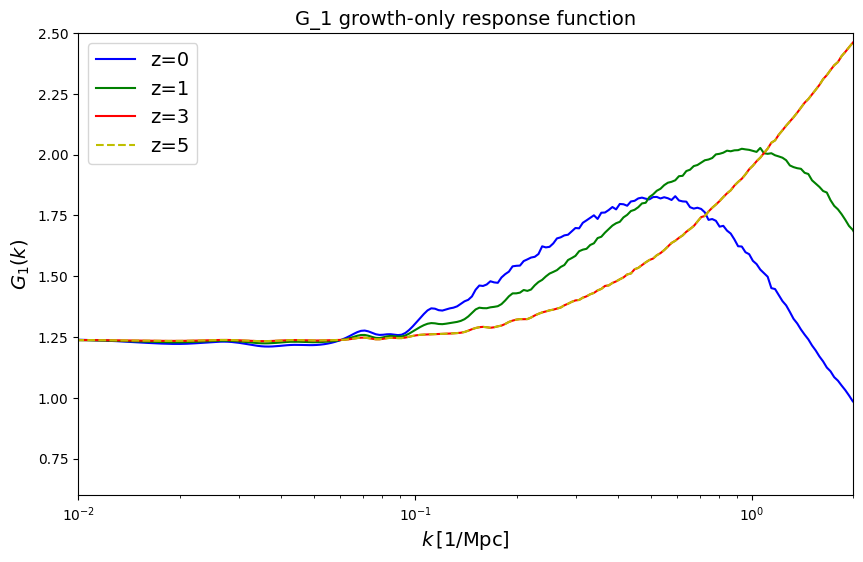

In [31]:
plt.figure(figsize=(10,6))
#plt.plot(k_arr, RF_G_1_k_z_table(k_arr, 0.0), c='b', ls='dashed', label='z=0 (table)')
plt.plot(k_arr, np.array([compute_RF_G_1_k_z(k, 0.0) for k in k_arr], dtype=object), c='b', ls='solid', label='z=0')
plt.plot(k_arr, np.array([compute_RF_G_1_k_z(k, 1.0) for k in k_arr], dtype=object), c='g', ls='solid', label='z=1')
plt.plot(k_arr, np.array([compute_RF_G_1_k_z(k, 3.0) for k in k_arr], dtype=object), c='r', ls='solid', label='z=3')
plt.plot(k_arr, np.array([compute_RF_G_1_k_z(k, 5.0) for k in k_arr], dtype=object), c='y', ls='dashed', label='z=5')
plt.xscale('log')
plt.xlim(1e-2, 2)
plt.ylim(0.6, 2.5)
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$G_1(k)$',fontsize=14)
plt.legend(fontsize=14)
plt.title('G_1 growth-only response function',fontsize=14)

Text(0.5, 1.0, 'G_K growth-only response function')

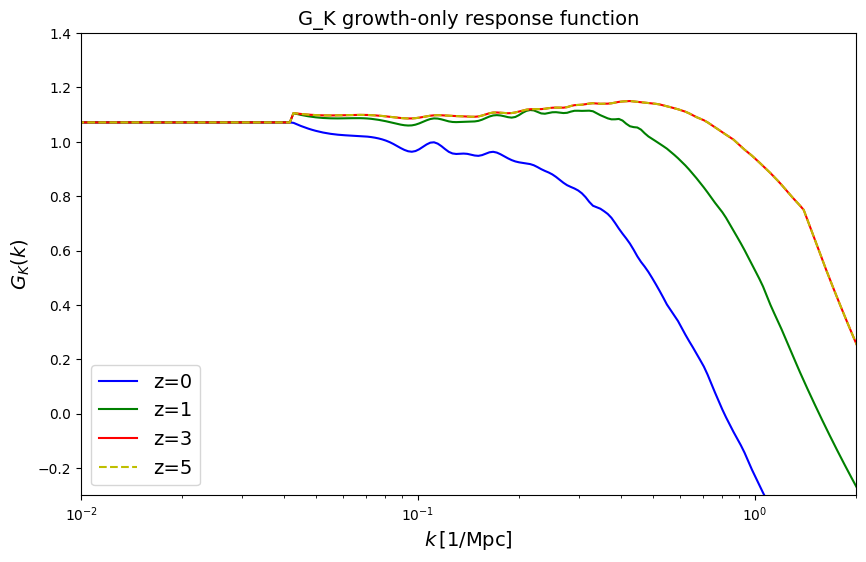

In [32]:
plt.figure(figsize=(10,6))
#plt.plot(k_arr, RF_G_K_k_z_table(k_arr, 0.0), c='b', ls='dashed', label='z=0 (table)')
plt.plot(k_arr, np.array([compute_RF_G_K_k_z(k, 0.0) for k in k_arr], dtype=object), c='b', ls='solid', label='z=0')
plt.plot(k_arr, np.array([compute_RF_G_K_k_z(k, 1.0) for k in k_arr], dtype=object), c='g', ls='solid', label='z=1')
plt.plot(k_arr, np.array([compute_RF_G_K_k_z(k, 3.0) for k in k_arr], dtype=object), c='r', ls='solid', label='z=3')
plt.plot(k_arr, np.array([compute_RF_G_K_k_z(k, 5.0) for k in k_arr], dtype=object), c='y', ls='dashed', label='z=5')
plt.xscale('log')
plt.xlim(1e-2, 2)
plt.ylim(-0.3, 1.4)
plt.xlabel(r'$k \, [1/\mathrm{Mpc}]$', fontsize=14)
plt.ylabel(r'$G_K(k)$',fontsize=14)
plt.legend(fontsize=14)
plt.title('G_K growth-only response function',fontsize=14)